# **Настройки + библиотеки**

In [2]:
!pip install tabgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.5 MB/s eta 0:00:00


In [3]:
# библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tabgan.sampler import OriginalGenerator, GANGenerator, ForestDiffusionGenerator
%matplotlib inline
# подключение диска
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/_ctgan/synthesizer.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Mounted at /content/drive


In [4]:
# датасет
dataset_path = '/content/drive/My Drive/Bases/WIND_DBASE/dag_2011_2022_final.csv'

# интесесущая станция
st_name = 'Кочубей'

# интересующие признаки данных
col_list = ['datetime',
            't_air', 't_soil', 'P_atm', 'wind_dir', 'wind_speed']

# границы обучающей выборки
train_borders = ['2011-01-01 00:00:00', '2020-12-31 21:00:00']
# границы проверочной выборки
val_borders = ['2021-01-01 00:00:00', '2021-12-31 21:00:00']
# границы тестовой выборки
test_borders = ['2022-01-01 00:00:00', '2022-12-31 21:00:00']

# **Функции**

**Общие функции**

In [5]:
# подготовка датасета (чтение, выделение признаков, нормировка, класс ветра)
# path - путь к исходнику
# st_name - название станции
# col_list - колонки признаков
# mode = 'category' / 'values'
def process_dataset(path, st_name, col_list, norm_0_1=False):
  # читаем данные
  df = pd.read_csv(path)
  # выделяем станцию
  df = df[df.st_name == st_name]
  # выделяем признаки
  df = df[col_list]
  # перевод градусов угла направления ветра в индекс лепестка розы ветров [0..7]
  def conv_360_to_8(val):
    if val >= 360:
      return 0
    else:
      return val // 45
    return res
  def conv_360_to_16(val):
    if val >= 360:
      return 0
    else:
      return val // 22.5
    return res
  df['wind_dir'] = df['wind_dir'].apply(conv_360_to_16).astype('int32')

  # округление температуры воздуха
  df['t_air'] = df['t_air'].astype('int32')
  # приведение температуры воздуха к категориям от 0
  df['t_air'] = df['t_air'] - df['t_air'].min()

  # округление температуры почвы
  df['t_soil'] = df['t_soil'].astype('int32')
  # приведение температуры воздуха к категориям от 0
  df['t_soil'] = df['t_soil'] - df['t_soil'].min()

  # округление атмосферного давления
  df['P_atm'] = df['P_atm'].astype('int32')
  # приведение температуры воздуха к категориям от 0
  df['P_atm'] = df['P_atm'] - df['P_atm'].min()

  # приводим скорости ветра к 3 классам:
  # 0 - от 0 до 3 м/с
  # 1 - от 4 до 7 м/с
  # 2 - от 8 м/с и выше
  def wind_to_class(x):
    if x < 4:
      res = 0
    elif x < 8:
      res = 1
    else:
      res = 2
    return res
  df['wind_class'] = df['wind_speed'].apply(wind_to_class).astype('int32')

  if norm_0_1:
    # нормировка столбцов [0..1]
    for col in col_list[1:]:
      a = df[col].min()
      b = df[col].max()
      df[col] = (df[col] - a)/(b - a)
      df[col] = df[col].astype('float32')

  return df

# нарезка примеров из датафрейма
# df - исходный датафрейм
# days - размер блока данных для X примера (по умолчанию 1 день)
# col_list - колонки c которыми делается выборка
# borders - список из двух значений - границ выборки
def create_samples(df, col_list, borders, days_count=1):
  # выделение данных по границам времени
  rab_df = df[(df.datetime >= borders[0]) & (df.datetime <= borders[1])]
  # размер блока данных
  block_size = days_count * 8
  # начальная позиция текущего смещения в датасете
  pos = 0
  # обнуляем списки примеров...
  samples_x = []
  samples_y = []
  # флаг остановки цикла
  Ex = False
  # нарезка данных в цикле
  while not Ex:
    # если не дошли до конца....
    if pos + block_size < rab_df.shape[0]:
      # формирование вектора X для всех колонок
      x_vec = []
      for col in col_list:
        x_vec.extend(rab_df[col][pos:pos+block_size].to_list())
      # формирование вектора Y
      y_vec = utils.to_categorical(rab_df['wind_class'][pos+block_size:pos+block_size+1].to_list()[0], 3).astype('int')
      # добавление векторов в списки примеров
      samples_x.append(x_vec)
      samples_y.append(y_vec)
    else:
      # прекращение нарезки когда доходим до конца
      Ex = True
    # сдвиг позиции нарезки
    pos += 1 # сдвигаем позицию на 1
  # результат в numpy массивах
  return np.array(samples_x), np.array(samples_y)

# получение весов классов
# df - исходный датафрейм
# borders - список из двух значений - границ выборки
def get_class_weights(df, borders, class_num=3):
  rab_df = df[(df.datetime >= borders[0]) & (df.datetime <= borders[1])]['wind_class']
  class_weights = {}
  for i in range(class_num):
    class_weights[i] = 1.0 / rab_df.value_counts()[i]
  return class_weights

# график обучения
def fit_chart(history):
  # для размера графика...
  def cm_to_inch(value):
    return value/2.54
  plt.figure(figsize=(cm_to_inch(30),cm_to_inch(15)))
  plt.plot([x for x in range(1, len(history.history['accuracy'])+1)],
           history.history['accuracy'],
           label='Точность на обучающем наборе', linewidth=3)
  plt.plot([x for x in range(1, len(history.history['val_accuracy'])+1)],
           history.history['val_accuracy'],
           label='Точность на проверочном наборе', linewidth=3)
  plt.xlabel('Эпоха обучения', fontsize=14)
  plt.ylabel('Точность', fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(True)
  plt.legend(fontsize=14)
  plt.show()

# на основе проверочной или тестовой выборки
# возвращает:
# 1. Точность предсказания
# 2. Список точностей для классов
# 3. Матрицу несоответствий
def get_accuracy_report(model, x, y, class_num=3):
  # предикт
  pred = model.predict(x)
  # массив предсказанных y_pred
  y_pred = []
  for i in range(pred.shape[0]):
    y_pred.append(np.argmax(pred[i]))
  y_pred = np.array(y_pred)
  # numpy массив истинных y_true
  y_true = []
  for i in range(y.shape[0]):
    y_true.append(np.argmax(y[i]))
  y_true = np.array(y_true)
  # матрица несоответсвий
  cm = confusion_matrix(y_true, y_pred)
  res = [None for i in range(class_num)]
  for i in range(class_num):
    res[i] = round(cm[i, i]/(cm[i, :].sum()),3)
  return accuracy_score(y_true, y_pred), res, cm


**Модели**

In [6]:
# только полноcвязный слой
def create_model_dense(x_len, params):

  input = Input((x_len,))

  x = BatchNormalization()(input)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)

# модель со сверточными слоями А
def create_model_conv_a(x_len, params, bs):

  blocks_count = round(x_len / bs)

  input = Input((x_len,))

  xx = [None for i in range(blocks_count)]

  for i in range(blocks_count):

    xx[i] = Reshape((bs, 1))(input[:,i*bs:i*bs+bs])

    #xx[i] = SpatialDropout1D(0.1)(xx[i])
    xx[i] = Conv1D(10, 5, activation=params['activation'])(xx[i])

    xx[i] = Flatten()(xx[i])

  x = concatenate(xx)

  x = BatchNormalization()(x)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)

# модель со сверточными слоями B
def create_model_conv_b(x_len, params):

  input = Input((x_len,))

  x = Reshape((x_len, 1))(input)

  x1 = Conv1D(10, 3, activation=params['activation'])(x)
  x1 = Flatten()(x1)

  x2 = Conv1D(10, 5, activation=params['activation'])(x)
  x2 = Flatten()(x2)

  x3 = Conv1D(10, 7, activation=params['activation'])(x)
  x3 = Flatten()(x3)

  x = concatenate([x1, x2, x3])

  x = BatchNormalization()(x)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)

# модель со сверточными слоями А
def create_model_lstm(x_len, params, bs):

  blocks_count = round(x_len / bs)

  input = Input((x_len,))

  xx = [None for i in range(blocks_count)]

  for i in range(blocks_count):

    xx[i] = Reshape((bs, 1))(input[:,i*bs:i*bs+bs])

    #xx[i] = SpatialDropout1D(0.1)(xx[i])
    xx[i] = LSTM(16, return_sequences=True)(xx[i])

    xx[i] = Flatten()(xx[i])

  x = concatenate(xx)

  x = BatchNormalization()(x)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)



**Компиляция и обучение моделей**

In [7]:
# компиляция модели
def compile_model(model, params):
  model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                loss=['categorical_crossentropy'],
                metrics=['accuracy'])

# обучение модели
def fitting_model(model, params, x_train, y_train, x_val, y_val):
  # колбэк
  checkpoint = ModelCheckpoint('best_model.h5',
                               monitor = 'val_accuracy',
                               verbose = 0,
                               save_best_only=True,
                               mode='max')
  # обучение
  history = model.fit(x_train, y_train,
                      batch_size = params['batch_size'],
                      epochs= params['epochs_count'],
                      validation_data=(x_val, y_val),
                      class_weight=params['class_weight'],
                      verbose=1, callbacks=[checkpoint])
  # загрузка весов
  model.load_weights('best_model.h5')

  return history


**GAN - Генеративно состязательная сеть для выравнивания классов датасета**

In [8]:
# из numpy массивов тестовой выборки переброс данных в датафрейм
def df_from_np(x, y):
  df = pd.DataFrame(x)
  y1 = []
  for i in range(y.shape[0]):
    y1.append(np.argmax(y[i]))
  df['y'] = y1
  return df

# **Чтение и обработка данных, подготовка примеров**

In [9]:
#загрузка и предобработка данных
df = process_dataset(dataset_path, st_name, col_list)
df

,datetime,t_air,t_soil,P_atm,wind_dir,wind_speed,wind_class
2,2011-01-01 00:00:00,33,34,26,15,3,0
6,2011-01-01 03:00:00,33,33,25,15,3,0
9,2011-01-01 06:00:00,33,33,27,13,3,0
14,2011-01-01 09:00:00,32,34,27,13,4,1
17,2011-01-01 12:00:00,31,32,27,13,3,0
...,...,...,...,...,...,...,...
139988,2022-12-31 09:00:00,33,38,38,0,0,0
139993,2022-12-31 12:00:00,36,37,37,6,1,0
139998,2022-12-31 15:00:00,32,28,37,0,0,0
140000,2022-12-31 18:00:00,29,28,42,0,0,0


In [10]:
# количество дней в блоке данных
days_count = 1
# нарезка примеров для обучения
train_x, train_y = create_samples(df, col_list[1:], train_borders, days_count=days_count)
# нарезка примеров для проверки
val_x, val_y = create_samples(df, col_list[1:], val_borders, days_count=days_count)
# нарезка примеров для теста
test_x, test_y = create_samples(df, col_list[1:], test_borders, days_count=days_count)
# размеры выборки
print('Обучающая:', train_x.shape,  train_y.shape)
print('Проверочная:', val_x.shape,  val_y.shape)
print('Тестовая:', test_x.shape,  test_y.shape)
# настройка весов классов для обучающей выборки
class_weight = get_class_weights(df, train_borders)
print(class_weight)

Обучающая: (29216, 40) (29216, 3)
Проверочная: (2912, 40) (2912, 3)
Тестовая: (2912, 40) (2912, 3)
{0: 6.947821857847565e-05, 1: 8.482483671218933e-05, 2: 0.0003287310979618672}


**Генерация выборки GAN**

In [11]:
# переброс данных из обучающих примеров в датафрейм
df = df_from_np(train_x, train_y)
df['y'].value_counts()

0    14386
1    11788
2     3042
Name: y, dtype: int64

In [ ]:
# переброс данных из проверочных примеров в датафрейм
#df_test = df_from_np(val_x, val_y)
#df_test['y'].value_counts()

In [ ]:
# берем с последнего класса 3042 значения, а с остальних семплируем такое же количество примеров
#df0 = pd.concat([df[df['y']==2], df[df['y']==0].sample(len(df[df['y']==2])),
#                df[df['y']==1].sample(len(df[df['y']==2]))])
# перемешиваем
#df0 = df0.sample(frac=1)
#df0['y'].value_counts()

In [ ]:
# генерируем выборку через GAN
df_gan1, y1 = OriginalGenerator(gen_x_times=10).generate_data_pipe(df.drop(['y'], axis=1), df[['y']], df.drop(['y'], axis=1), )
df_gan2, y2 = GANGenerator(gen_x_times=10).generate_data_pipe(df.drop(['y'], axis=1), df[['y']], df.drop(['y'], axis=1), )
df_gan1['y'] = y1
df_gan2['y'] = y2
df_gan = pd.concat([df_gan1, df_gan2])

In [ ]:
df_gan['y'].value_counts()

0    91191
1    64396
2    20032
Name: y, dtype: int64

In [12]:
#gan_path = '/content/drive/My Drive/Bases/WIND_DBASE/kochubey_train_gan_1.csv'
#df_gan.to_csv(gan_path, index=False)
df_gan = pd.read_csv('/content/drive/My Drive/Bases/WIND_DBASE/kochubey_train_gan_1.csv')

In [ ]:
# группируем данные 0 и 1 классы из старой выборки, 2 класс из сгенерированной
#df_new = pd.concat([df[df['y']<2], df_gan[df_gan['y']==2]])
# перемешиваем
#df_new = df_new.sample(frac=1)
#df_new['y'].value_counts()

In [13]:
# формируем новые массивы для обучения
train_x_new = np.array(df_gan.drop(['y'], axis=1))
train_y_new = utils.to_categorical(df_gan['y'].to_list(), 3).astype('int')
print(train_x_new.shape)
print(train_y_new.shape)

(175619, 40)
(175619, 3)


In [14]:
class_weight = {}
for i in range(3):
  class_weight[i] = 1.0 / df_gan['y'].value_counts()[i]

# **ОБУЧЕНИЕ МОДЕЛЕЙ**

**Полносвязные слои**

In [15]:
# параметры обучения
model_params = {'batch_size' : 500,
                'dropout' : 0.3,
                'activation' : 'relu',
                'epochs_count' : 300,
                'learning_rate' : 1e-4,
                'class_weight': class_weight}

In [16]:
# создание модели
model = create_model_dense(train_x_new.shape[1], model_params)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x_new,
                        train_y_new,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
352/352 [==============================] - 6s 5ms/step - loss: 1.7788e-05 - accuracy: 0.4256 - val_loss: 0.8950 - val_accuracy: 0.5951
Epoch 2/300
352/352 [==============================] - 2s 5ms/step - loss: 1.6435e-05 - accuracy: 0.4987 - val_loss: 0.8178 - val_accuracy: 0.6343
Epoch 3/300
352/352 [==============================] - 2s 5ms/step - loss: 1.6028e-05 - accuracy: 0.5197 - val_loss: 0.7818 - val_accuracy: 0.6587
Epoch 4/300
352/352 [==============================] - 2s 6ms/step - loss: 1.5807e-05 - accuracy: 0.5302 - val_loss: 0.7721 - val_accuracy: 0.6635
Epoch 5/300
352/352 [==============================] - 2s 6ms/step - loss: 1.5640e-05 - accuracy: 0.5375 - val_loss: 0.7557 - val_accuracy: 0.6710
Epoch 6/300
352/352 [==============================] - 2s 5ms/step - loss: 1.5498e-05 - accuracy: 0.5422 - val_loss: 0.7475 - val_accuracy: 0.6731
Epoch 7/300
352/352 [==============================] - 2s 6ms/step - loss: 1.5355e-05 - accuracy: 0.5474 - val_loss: 0

In [17]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 81.2 %
Точность класса 1: 63.9 %
Точность класса 2: 71.6 %
[[1236  272   15]
 [ 283  676   99]
 [  12   82  237]]
Общая точность: 0.7379807692307693


In [18]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 91.9 %
Точность класса 1: 60.9 %
Точность класса 2: 65.0 %
[[2335  203    4]
 [ 112  213   25]
 [   1    6   13]]
Общая точность: 0.8794642857142857


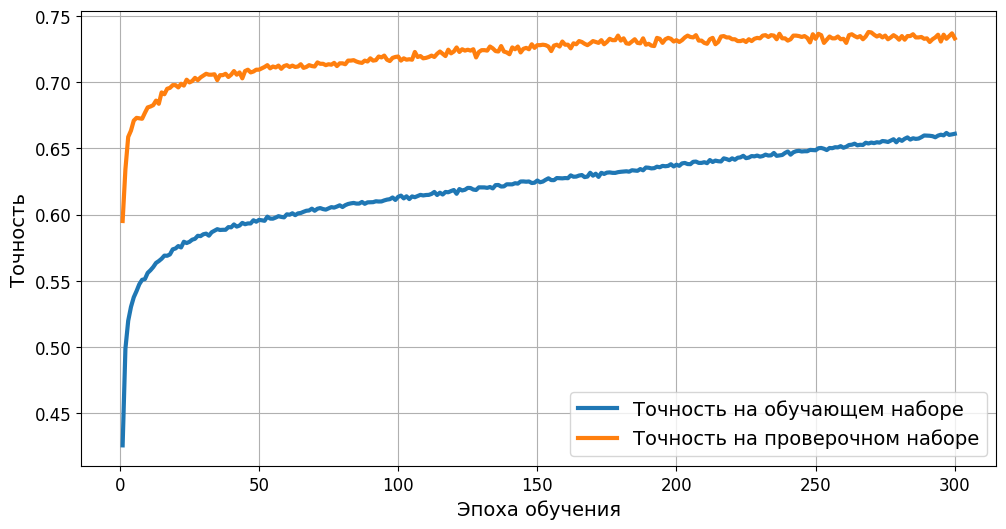

In [19]:
fit_chart(history)

**Сверточные слои А**

In [20]:
block_size = days_count*8

# создание модели
model = create_model_conv_a(train_x.shape[1], model_params, block_size)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
59/59 [==============================] - 5s 20ms/step - loss: 1.9099e-05 - accuracy: 0.3326 - val_loss: 1.0217 - val_accuracy: 0.4512
Epoch 2/300
59/59 [==============================] - 1s 12ms/step - loss: 1.7175e-05 - accuracy: 0.4501 - val_loss: 0.9808 - val_accuracy: 0.4973
Epoch 3/300
59/59 [==============================] - 1s 11ms/step - loss: 1.5987e-05 - accuracy: 0.5072 - val_loss: 0.9293 - val_accuracy: 0.5340
Epoch 4/300
59/59 [==============================] - 1s 12ms/step - loss: 1.5223e-05 - accuracy: 0.5376 - val_loss: 0.8762 - val_accuracy: 0.5673
Epoch 5/300
59/59 [==============================] - 1s 12ms/step - loss: 1.4721e-05 - accuracy: 0.5538 - val_loss: 0.8363 - val_accuracy: 0.6034
Epoch 6/300
59/59 [==============================] - 1s 13ms/step - loss: 1.4369e-05 - accuracy: 0.5723 - val_loss: 0.8092 - val_accuracy: 0.6233
Epoch 7/300
59/59 [==============================] - 1s 12ms/step - loss: 1.4039e-05 - accuracy: 0.5819 - val_loss: 0.7931 -

In [21]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 79.8 %
Точность класса 1: 63.1 %
Точность класса 2: 70.1 %
[[1216  287   20]
 [ 289  668  101]
 [  10   89  232]]
Общая точность: 0.7266483516483516


In [22]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 91.5 %
Точность класса 1: 62.3 %
Точность класса 2: 50.0 %
[[2326  211    5]
 [ 117  218   15]
 [   1    9   10]]
Общая точность: 0.8770604395604396


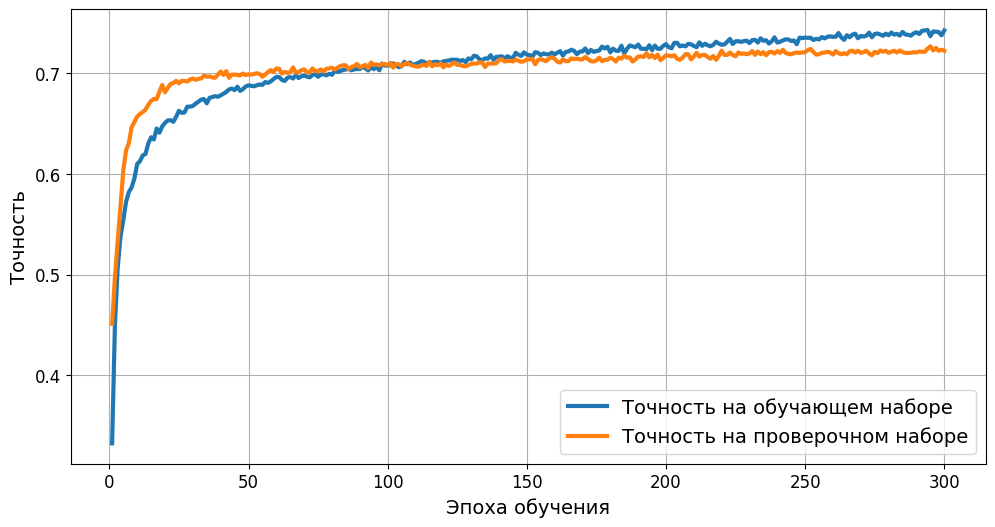

In [23]:
fit_chart(history)

**Сверточные слои B**

In [24]:
# создание модели
model = create_model_conv_b(train_x.shape[1], model_params)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
59/59 [==============================] - 6s 47ms/step - loss: 2.0355e-05 - accuracy: 0.3542 - val_loss: 1.1863 - val_accuracy: 0.3846
Epoch 2/300
59/59 [==============================] - 2s 29ms/step - loss: 1.6807e-05 - accuracy: 0.4894 - val_loss: 0.9611 - val_accuracy: 0.5285
Epoch 3/300
59/59 [==============================] - 1s 20ms/step - loss: 1.5652e-05 - accuracy: 0.5327 - val_loss: 0.8691 - val_accuracy: 0.5872
Epoch 4/300
59/59 [==============================] - 1s 17ms/step - loss: 1.5013e-05 - accuracy: 0.5559 - val_loss: 0.8350 - val_accuracy: 0.6027
Epoch 5/300
59/59 [==============================] - 1s 16ms/step - loss: 1.4339e-05 - accuracy: 0.5747 - val_loss: 0.7940 - val_accuracy: 0.6312
Epoch 6/300
59/59 [==============================] - 1s 16ms/step - loss: 1.3879e-05 - accuracy: 0.5943 - val_loss: 0.7785 - val_accuracy: 0.6350
Epoch 7/300
59/59 [==============================] - 1s 17ms/step - loss: 1.3553e-05 - accuracy: 0.5990 - val_loss: 0.7464 -

In [25]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 81.9 %
Точность класса 1: 63.0 %
Точность класса 2: 70.1 %
[[1248  257   18]
 [ 298  667   93]
 [  10   89  232]]
Общая точность: 0.7372939560439561


In [26]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 91.4 %
Точность класса 1: 61.4 %
Точность класса 2: 45.0 %
[[2324  216    2]
 [ 118  215   17]
 [   0   11    9]]
Общая точность: 0.875


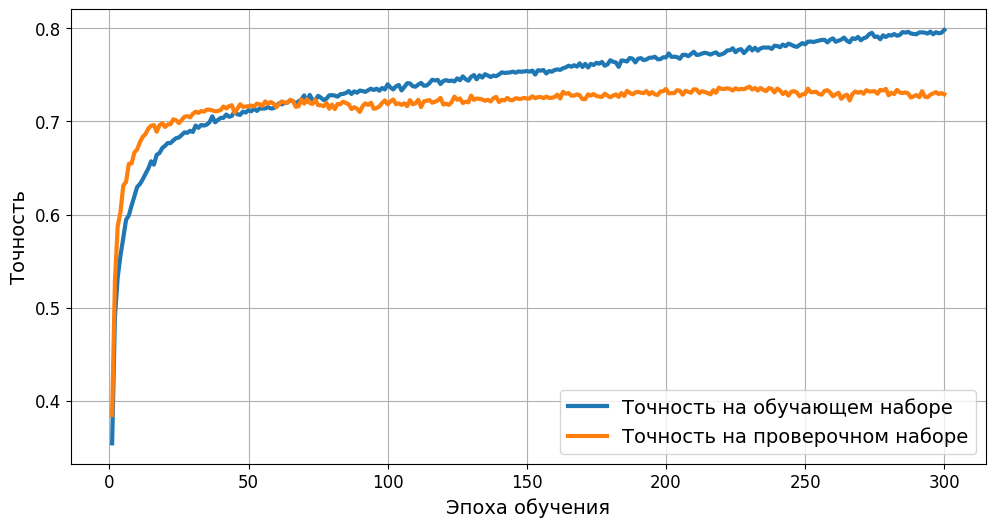

In [27]:
fit_chart(history)

**lstm**

In [28]:
block_size = days_count*8

# создание модели
model = create_model_lstm(train_x.shape[1], model_params, block_size)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
59/59 [==============================] - 13s 46ms/step - loss: 1.8608e-05 - accuracy: 0.3939 - val_loss: 1.1634 - val_accuracy: 0.1240
Epoch 2/300
59/59 [==============================] - 1s 16ms/step - loss: 1.6350e-05 - accuracy: 0.4936 - val_loss: 1.0879 - val_accuracy: 0.3520
Epoch 3/300
59/59 [==============================] - 1s 22ms/step - loss: 1.5370e-05 - accuracy: 0.5377 - val_loss: 1.0327 - val_accuracy: 0.5189
Epoch 4/300
59/59 [==============================] - 1s 22ms/step - loss: 1.4760e-05 - accuracy: 0.5601 - val_loss: 0.9762 - val_accuracy: 0.5859
Epoch 5/300
59/59 [==============================] - 1s 22ms/step - loss: 1.4228e-05 - accuracy: 0.5773 - val_loss: 0.9162 - val_accuracy: 0.6219
Epoch 6/300
59/59 [==============================] - 1s 20ms/step - loss: 1.3824e-05 - accuracy: 0.5974 - val_loss: 0.8679 - val_accuracy: 0.6298
Epoch 7/300
59/59 [==============================] - 1s 15ms/step - loss: 1.3486e-05 - accuracy: 0.6055 - val_loss: 0.8276 

In [29]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 2s 4ms/step
Точность класса 0: 81.0 %
Точность класса 1: 59.9 %
Точность класса 2: 74.0 %
[[1234  265   24]
 [ 302  634  122]
 [  11   75  245]]
Общая точность: 0.7256181318681318


In [30]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 4ms/step
Точность класса 0: 93.4 %
Точность класса 1: 59.4 %
Точность класса 2: 45.0 %
[[2375  165    2]
 [ 121  208   21]
 [   0   11    9]]
Общая точность: 0.8901098901098901


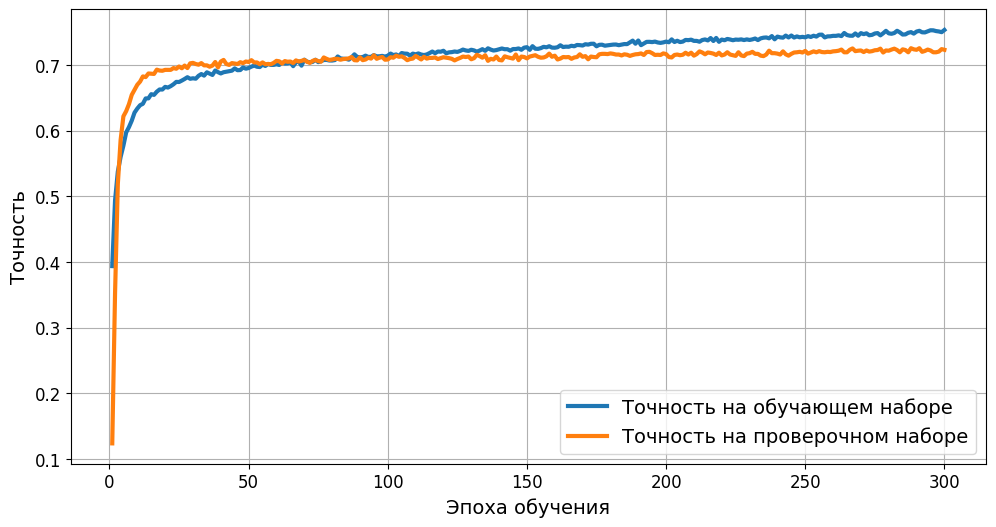

In [31]:
fit_chart(history)